In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import pickle
from itertools import product
import functools
import seaborn as sns
from plotnine import *
from plotnine.data import *
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

def plot_histogram(df, var, title): 
    plot = (ggplot(data = df, 
               mapping = aes(x = var)) +
             geom_histogram(colour = "black", fill = "white") +
     # 25% quantile
      geom_vline(aes(xintercept=df[var].quantile(.25)),
                color="blue", linetype="dashed", size=1) +
     # median
     geom_vline(aes(xintercept=df[var].quantile(.5)),
                color="blue", linetype="dashed", size=1)+
     # mean
     geom_vline(aes(xintercept=df[var].mean()),
                color="red", linetype="dashed", size=1)+
      # 75% quantile
      geom_vline(aes(xintercept=df[var].quantile(.75)),
                color="blue", linetype="dashed", size=1) +
     theme(element_text(angle = 90, vjust = 0.5, hjust=1)) +
     ggtitle(title)
    )
    
    print(plot)

In [2]:
# Grab more data early to prevent NAs when calculating returns later
quandl.ApiConfig.api_key = 'jJeFoAcYubSY8xDcp3oy'
RYE = quandl.get_table('QUOTEMEDIA/PRICES', \
                       date = [d.strftime('%Y-%m-%d')\
                               for d in pd.date_range('20150101','20211130')], \
                       ticker='RYE')

In [3]:
RYE = RYE.set_index("date").sort_index()

In [23]:
cones = []
for i in range(1, 60):
    day_of_interest = "2021-11-23"
    df = RYE.loc[:day_of_interest].copy()
    df["return"] = df["adj_close"] / df["adj_close"].shift(1) - 1
    df["vol"] = df["return"].rolling(i).std() * np.sqrt(252)
    df = df.reset_index()
    df = df.dropna()
    df = df.groupby(df.index // 10).filter(lambda x: len(x) == 10).copy()
    df["rank"] = df.groupby(df.index // 10)["vol"].transform(pd.qcut,10, range(1, 11))
    # mean table / should try add exponential weighting 
    df = pd.DataFrame({"cone" : df.groupby("rank")["vol"].mean()})
    df = df.reset_index(drop = False)
    df["days to expiry"] = i
    
    cones.append(df)

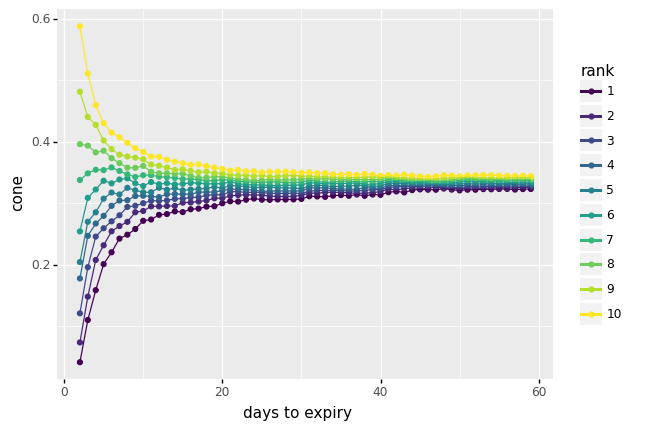

<ggplot: (355282978)>

In [24]:
(ggplot(data = pd.concat(cones), mapping= aes(x = "days to expiry", y = "cone", color = "rank")) +
geom_point() +
geom_line())